In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from utils import data_path

# Load data

In [2]:
simus = ['ssp126',
        'ssp370',
         #'ssp370-lowNTCF',
         'ssp585']

In [3]:
X_train = []
Y_train = []

for i,simu in enumerate(simus): 
    input_name = 'inputs_' + simu + '.nc'
    output_name = 'outputs_' + simu + '.nc'
    
    mbr = 1
    # load inputs 
    input_xr = xr.open_mfdataset([data_path + 'inputs_historical.nc', 
                             data_path + input_name]).compute()
        
    # load outputs                                                             
    output_xr = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2),
                     xr.open_dataset(data_path + output_name).sel(member=mbr)], dim='time').compute()
    output_xr = output_xr.assign({"pr": output_xr.pr * 86400, "pr90": output_xr.pr90 * 86400}).rename({'lon':'longitude', 
                         'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['member','quantile'])
    
    # Append to list 
    X_train.append(input_xr)
    Y_train.append(output_xr)

# Data normalization

In [4]:
minmax_inputs = {'CO2': [0, 10000],
 'CH4': [0, 1],
 'BC': [0, 6e-11],
 'SO2': [0, 2e-09]}

In [5]:
minmax_outputs = {'tas': [-7, 15],
 'diurnal_temperature_range': [-2.25, 6],
 'pr': [-11, 14],
 'pr90': [-25.5, 35]}

In [6]:
# Utilities for normalizing the emissions data
def normalize(data, var, minmax_dict): 
    min_var = minmax_dict[var][0]
    max_var = minmax_dict[var][1]
    return (data-min_var) / (max_var-min_var)

def unnormalize(data, var, minmax_dict):
    min_var = minmax_dict[var][0]
    max_var = minmax_dict[var][1]
    return data * (max_var-min_var)+ min_var

In [7]:
# normalize data 
X_train_norm = [] 
for i,train_xr in enumerate(X_train): 
    for var in ['CO2', 'CH4', 'SO2', 'BC']: 
        var_dims = train_xr[var].dims
        train_xr=train_xr.assign({var: (var_dims,normalize(train_xr[var].data, var, minmax_inputs))}) 
    X_train_norm.append(train_xr)
        
Y_train_norm = []
for i,train_xr in enumerate(Y_train): 
    for var in ['tas', 'diurnal_temperature_range', 'pr', 'pr90']: 
        var_dims = train_xr[var].dims
        train_xr=train_xr.assign({var: (var_dims,normalize(train_xr[var].data, var, minmax_outputs))}) 
    Y_train_norm.append(train_xr)

## Reshape data to feed into the model 

In [10]:
slider = 10 # years moving temporal window 

In [21]:
# Functions for reshaping the data 
def input_for_training(X_train_xr): 
    
    X_train_reshaped = xr.Dataset.from_dataframe(X_train_xr.to_dataframe())
    X_train_np = np.array([X_train_reshaped['CO2'].data, X_train_reshaped['CH4'].data, X_train_reshaped['SO2'].data, X_train_reshaped['BC'].data])
    X_train_np = X_train_np.transpose(1,3,2,0)
    time_length = X_train_np.shape[0]
    X_train_to_return = np.array([X_train_np[i:i+slider,...] for i in range(0,time_length-slider)])
    return X_train_to_return 

def output_for_training(Y_train_xr, var): 
    Y_train_np = Y_train_xr[var].data    
    time_length = Y_train_np.shape[0]
    Y_train_to_return = np.array([[Y_train_np[i+slider-1,...]] for i in range(0,time_length-slider)])
    return Y_train_to_return

# CNN - LSTM architecture
## Test on one variable
## Build model

In [22]:
var_to_predict =  'tas' 
X_train_all = np.concatenate([input_for_training(X_train_norm[i]) for i in range(len(simus))],axis = 0)
Y_train_all = np.concatenate([output_for_training(Y_train_norm[i], var_to_predict) for i in range(len(simus))], axis=0)
X_train_all.shape, Y_train_all.shape

((723, 10, 96, 144, 4), (723, 1, 96, 144))

inspo: https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [23]:
import keras
from keras import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2

In [24]:
keras.backend.clear_session()
cnn_model = None

In [25]:
import random 
random.seed(13)

In [26]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='relu'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))


Maybe add regularization : https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/ and batch normalization (scale inputs in between layers) https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/  and learning rate optimizer: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/ 

In [27]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 96, 144, 20)  740       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 48, 72, 20)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 20)           0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 13824)             359424    
                                                        

In [28]:
cnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"]) 

# Train model

In [29]:
X_train_all.shape,Y_train_all.shape

((723, 10, 96, 144, 4), (723, 1, 96, 144))

In [30]:
hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     #use_multiprocessing = True, 
                     #workers = 5, 
                     batch_size=5,
                     epochs=20,
                     verbose=1)

Epoch 1/20


2022-04-01 17:29:34.656556: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1599160320 exceeds 10% of free system memory.


145/145 [==============================] - 15s 94ms/step - loss: 0.0340 - mse: 0.0340
Epoch 2/20
145/145 [==============================] - 14s 95ms/step - loss: 0.0017 - mse: 0.0017
Epoch 3/20
145/145 [==============================] - 14s 94ms/step - loss: 0.0014 - mse: 0.0014
Epoch 4/20
145/145 [==============================] - 14s 93ms/step - loss: 0.0013 - mse: 0.0013
Epoch 5/20
145/145 [==============================] - 14s 94ms/step - loss: 0.0013 - mse: 0.0013
Epoch 6/20
145/145 [==============================] - 13s 92ms/step - loss: 0.0013 - mse: 0.0013
Epoch 7/20
145/145 [==============================] - 13s 93ms/step - loss: 0.0013 - mse: 0.0013
Epoch 8/20
145/145 [==============================] - 13s 93ms/step - loss: 0.0012 - mse: 0.0012
Epoch 9/20
145/145 [==============================] - 13s 92ms/step - loss: 0.0012 - mse: 0.0012
Epoch 10/20
145/145 [==============================] - 13s 91ms/step - loss: 0.0012 - mse: 0.0012
Epoch 11/20
145/145 [===================

In [31]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model


# Make final prediction for submission

In [32]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()
# normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test=X_test.assign({var: (var_dims,normalize(X_test[var].data, var, minmax_inputs))}) 
    
X_test_np = input_for_training(X_test)  

In [33]:
# Make predictions using trained model 
m_pred = cnn_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time','lat','lon'], coords= [X_test.time.data[slider:], X_test.latitude.data, X_test.longitude.data ])
# unnormalize 
m_pred.data = unnormalize(m_pred.data, var_to_predict, minmax_outputs)
m_pred = m_pred.transpose('lat','lon','time').sel(time=slice(2015,2101)).to_dataset(name=var_to_predict)
m_pred

<xarray.Dataset>
Dimensions:  (time: 86, lat: 96, lon: 144)
Coordinates:
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    tas      (lat, lon, time) float32 1.008 1.027 1.044 ... 5.786 5.804 5.822

tas


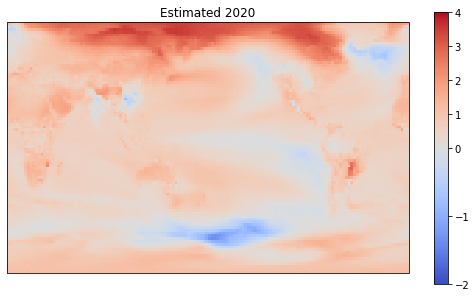

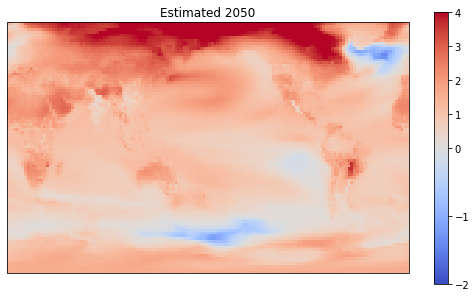

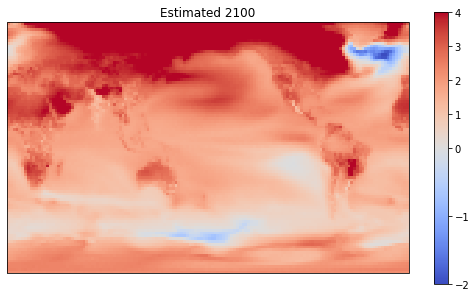

In [43]:
# Plot results 
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=4.)

print(var_to_predict)
for yr in [2020, 2050, 2100]: 
    f, axes = plt.subplots(1,1,
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(9, 5))

    ctr=axes.pcolormesh(m_pred[var_to_predict].sel(time=yr), cmap="coolwarm", norm=divnorm)
    plt.colorbar(ctr)
    axes.set_title(f"Estimated {yr}")

In [44]:
# unit conversion if applicable (i.e. for precipitation)
# m_pred = m_pred.assign({var: m_pred[var] / 86400})

In [45]:
import keras
from keras import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2
import random
random.seed(13)

In [46]:
# save test predictions as .nc 
output_name = 'outputs_ssp245_predict_pr_10to1_kern3_bs5.nc'
m_pred.to_netcdf(data_path+output_name)

# Run training and predictions for each target variable

In [47]:
vars_to_predict = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()
# normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test=X_test.assign({var: (var_dims,normalize(X_test[var].data, var, minmax_inputs))}) 
    
X_test_np = input_for_training(X_test)  

In [ ]:
for var_to_predict in vars_to_predict:
    
    print(var_to_predict)
    
    # Data
    X_train_all = np.concatenate([input_for_training(X_train_norm[i]) for i in range(len(simus))],axis = 0)
    Y_train_all = np.concatenate([output_for_training(Y_train_norm[i],var_to_predict) for i in range(len(simus))], axis=0)
    print(X_train_all.shape)
    print(Y_train_all.shape)
    
    # Model    
    keras.backend.clear_session()
    cnn_model = None
    
    cnn_model = Sequential()
    cnn_model.add(Input(shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'),input_shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(AveragePooling2D(2)))
    cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
    cnn_model.add(LSTM(25, activation = 'relu'))
    cnn_model.add(Dense(1*96*144))
    cnn_model.add(Activation('linear'))
    cnn_model.add(Reshape((1, 96, 144)))
    
    cnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"])
    
    hist = cnn_model.fit(X_train_all,
                         Y_train_all,
                         use_multiprocessing = True, 
                         #workers = 5, 
                         batch_size=5, epochs=20,  # 25 for tas,  5 for pr_3, pr, dtr_2  
                         verbose=1)
    
    # Make predictions using trained model 
    m_pred = cnn_model.predict(X_test_np)
    # reshape to xarray 
    m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
    m_pred = xr.DataArray(m_pred, dims=['time','lat','lon'], coords= [X_test.time.data[slider:], X_test.latitude.data, X_test.longitude.data ])
    # unnormalize 
    m_pred.data = unnormalize(m_pred.data, var_to_predict, minmax_outputs)
    xr_prediction = m_pred.transpose('lat','lon','time').sel(time=slice(2015,2101)).to_dataset(name=var_to_predict)

    if var_to_predict=="pr90" or var_to_predict=="pr":
        xr_prediction = xr_prediction.assign({var_to_predict: xr_prediction[var_to_predict] / 86400})

    # save test predictions as .nc 
    if var_to_predict == 'diurnal_temperature_range':
        xr_prediction.to_netcdf((data_path+'outputs_ssp245_predict_dtr.nc'),'w')

    else:
        xr_prediction.to_netcdf((data_path+'outputs_ssp245_predict_{}.nc').format(var_to_predict),'w')
    xr_prediction.close()
